<a href="https://colab.research.google.com/github/nnshoshin/projects/blob/main/praktikum_CV_Shoshin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста покупателей

## Задача

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. Добейтесь значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

Подгрузим необходимые библиотеки:

In [ ]:
# < Перенеситесюда исследовательский анализ данных >
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Загрузим полученные данные:

In [ ]:

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)  



Found 7591 validated image filenames.


Всего у нас 7591 фотографий в данных. 

Посмотрим на примеры фотографий:

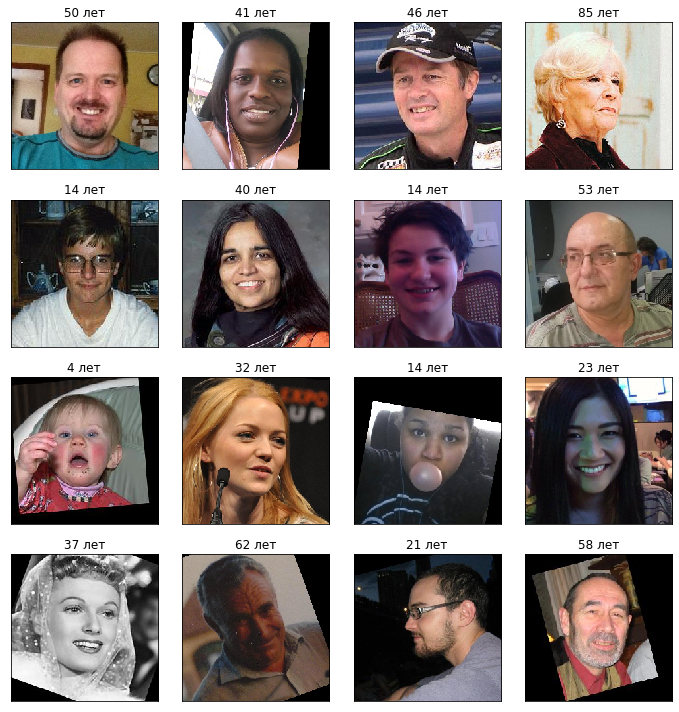

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    ax.title.set_text('{} лет'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Данные выглядят адекватно - у нас есть фотографии как детей, так и людей в возрасте. Посмотрим на распределение возрастов: 

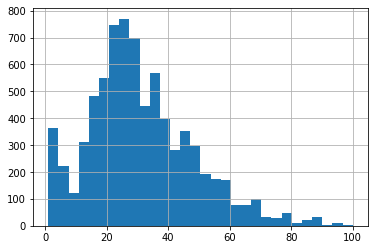

In [ ]:
labels['real_age'].hist(grid=True, bins = 30)

Мы видим, что в данных преобладает возрастная группа 18-40 лет. Также есть заметный пик от 0 до 3 - у нас много детских фотографий. Попробуем посмотреть на представителей этой группы, вдруг это какая-то ошибка или аномалия:

Found 237 validated image filenames.


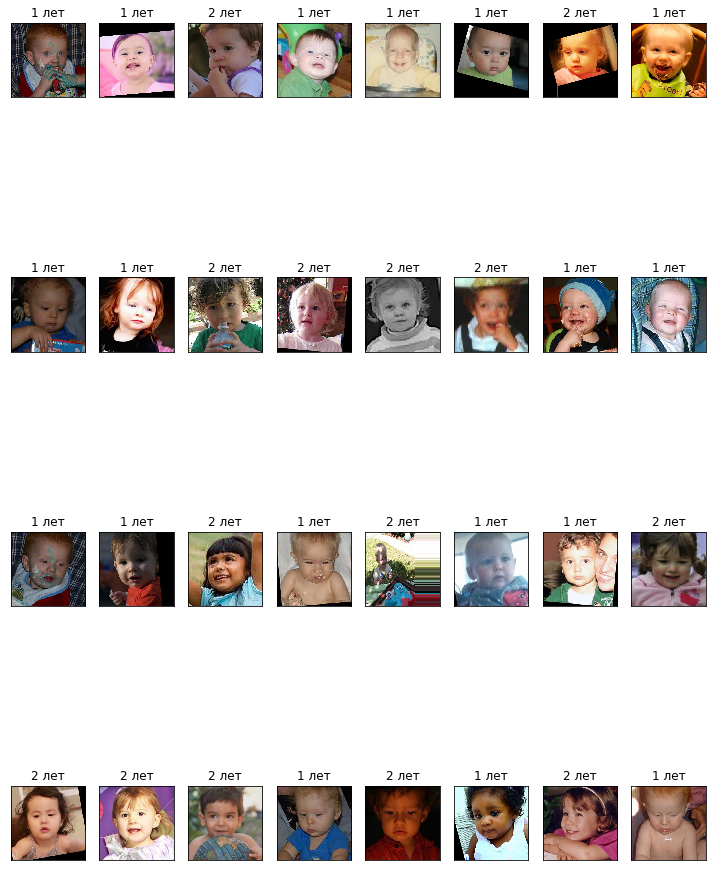

In [ ]:
kids = labels[labels['real_age']<3]

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=kids,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)  



features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,20))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    ax.title.set_text('{} лет'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видимо все ок, в данных очень много детских фотографий. С одной стороны, можно было бы их удалить, так как дети до 3 лет не могут быть самостоятельными покупателями в магазине. С другой стороны, они явно будут приходить со своими родителями, которым можно предлагать товары из особой детской категории. Поэтому всё-таки их оставим и приступим к обучению модели. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(        
        rescale=1 / 255.,
        validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow



def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='imagenet') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', metrics=['mae'], optimizer=optimizer)

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```

# < скопируйте результат вывода на экран сюда >

Train for 356 steps, validate for 119 steps
Epoch 1/5
2021-09-27 01:12:37.378819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-27 01:12:40.955624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 113s - loss: 199.5099 - mae: 10.1706 - val_loss: 397.1543 - val_mae: 14.9426
Epoch 2/5
356/356 - 37s - loss: 65.8322 - mae: 6.1875 - val_loss: 284.1875 - val_mae: 13.1018
Epoch 3/5
356/356 - 37s - loss: 36.3819 - mae: 4.6590 - val_loss: 74.6195 - val_mae: 6.5796
Epoch 4/5
356/356 - 37s - loss: 23.3601 - mae: 3.6774 - val_loss: 68.0314 - val_mae: 6.1554
Epoch 5/5
356/356 - 37s - loss: 17.9455 - mae: 3.2541 - val_loss: 69.8432 - val_mae: 6.4270
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 69.8432 - mae: 6.4270
Test MAE: 6.4270



```

## Анализ обученной модели

В ходе проекта удалось построить модель на основе ResNet, предсказыващую возраст с MAE на тестовой выборке 6.4, что удовлетворяет условию задачи. 